In [17]:
import pandas as pd
import numpy as np
import re
import gensim
import nltk
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer

In [5]:
df = pd.read_json('input/News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
print(df.shape)
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [9]:
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [11]:
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)     

In [18]:
final_df['length_of_news'] = final_df['length_of_news'].apply(datacleaning)

In [21]:
samples = list(final_df['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words

In [30]:
max_length = 15

results = np.zeros(shape=(len(samples),max_length,max(token_index.values()) +1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1
results[0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
from sklearn.preprocessing import LabelEncoder
X = final_df['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(final_df['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (209527,)
shape of target variable:  (209527,)


In [71]:
train_padseq[0]

array([21748,   897,   394,  2144,  3742, 57626,  1422,    75, 27104,
        1702, 11728,  3742,  9130,   844,  1850,  1718,   169,   328,
          57, 14161], dtype=int32)

In [43]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130 # max length of sequence 
y_train = to_categorical(y_train, num_classes=42)
y_test = to_categorical(y_test, num_classes=42)
print("Length of word index:", total_words)

Length of word index: 190761


In [94]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU

model = Sequential()
model.add(Embedding(total_words, 100, input_length=20))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 100)           19076100  
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 20, 128)           21120     
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 20, 128)           24704     
_________________________________________________________________
simple_rnn_33 (SimpleRNN)    (None, 64)                12352     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 42)                2730      
Total params: 19,137,006
Trainable params: 19,137,006
Non-trainable params: 0
_________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = EarlyStopping(monitor='accuracy',patience=5,verbose=1,mode='min')
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, epochs=15, validation_split=0.2, shuffle=True)

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
 232/4191 [>.............................] - ETA: 12:31 - loss: 3.5124 - accuracy: 0.1250

In [54]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU

model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 100)          19076100  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 130, 128)          84480     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 130, 128)          98816     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 130, 128)          24704     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 72)           27720     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 72)            0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 64, 64)           

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = EarlyStopping(monitor='accuracy',patience=5,verbose=1,mode='min')
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train, batch_size=128, epochs=5, validation_split=0.2,shuffle=True)

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/5
1048/1048 [==============================] - 187s 157ms/step - loss: 3.9801 - accuracy: 0.2857 - val_loss: 2.1560 - val_accuracy: 0.4624
Epoch 2/5
1048/1048 [==============================] - 158s 151ms/step - loss: 2.0072 - accuracy: 0.4964 - val_loss: 1.9359 - val_accuracy: 0.5122
Epoch 3/5
1048/1048 [==============================] - 164s 156ms/step - loss: 1.7348 - accuracy: 0.5616 - val_loss: 1.8379 - val_accuracy: 0.5377
Epoch 4/5
1048/1048 [==============================] - 158s 151ms/step - loss: 1.5610 - accuracy: 0.6025 - val_loss: 1.8160 - val_accuracy: 0.5457
Epoch 5/5
1048/1048 [==============================] - 156s 149ms/step - loss: 1.4116 - accuracy: 0.6416 - val_loss: 1.8182 - val_accuracy: 0.5449
test loss and accuracy: 1.799662470817566 0.5497781038284302


In [60]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

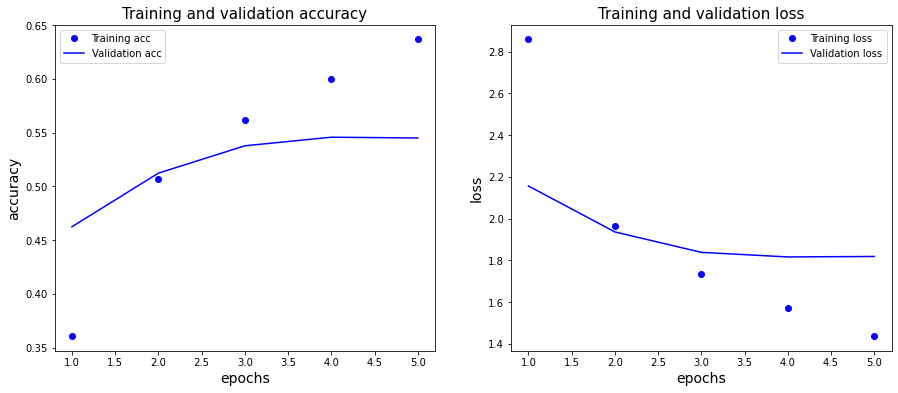

In [61]:
plot_loss_accuracy(history2)